In [4]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [5]:
# 2. Đọc file dữ liệu chứng khoán Vietcombank và chia tập train test theo tỉ lệ 7:3
df = pd.read_csv('Vietcombank.csv')
df = df[['Close', 'High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [6]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình ARIMA phù hợp nhất bằng auto_arima 
auto_arima(train_data['Close'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15302.688, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15303.604, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15303.593, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15300.951, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15305.575, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.365 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [7]:
model = VARMAX(train_data, order=(1, 1))
model_fit = model.fit(maxiter=1000, disp=False)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [8]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
close_pred = model_fit.forecast(steps=len(y_test))
y_pred = close_pred['Close'].to_numpy()

In [9]:
# 5. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Tạo một mảng gồm 90 số nguyên liên tiếp bắt đầu từ last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Dự đoán giá đóng cho 90 ngày tiếp theo
close_next_90_days = model_fit.forecast(steps=len(x_next_90_days))

y_next_90_days = close_next_90_days['Close'].to_numpy()

# In ra giá đóng đã được dự đoán trong 90 ngày tiếp theo
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[57597.58096994 57720.86717837 57771.45262693 57789.69967054
 57793.57481253 57791.07541775 57785.76125634 57779.21677795
 57772.14715199 57764.86615162 57757.51332713 57750.15067711
 57742.80567989 57735.49044838 57728.21025644 57720.96733428
 57713.76255792 57706.59620119 57699.46827054 57692.37865397
 57685.32718739 57678.31368416 57671.33794819 57664.39977979
 57657.49897828 57650.63534316 57643.80867458 57637.01877358
 57630.2654422  57623.54848352 57616.86770165 57610.22290174
 57603.61389001 57597.04047371 57590.50246111 57583.99966156
 57577.53188538 57571.09894394 57564.70064964 57558.33681586
 57552.00725701 57545.71178848 57539.45022667 57533.22238896
 57527.02809371 57520.86716027 57514.73940895 57508.64466105
 57502.5827388  57496.55346541 57490.55666504 57484.59216279
 57478.65978471 57472.75935778 57466.89070992 57461.05366996
 57455.24806767 57449.47373373 57443.73049974 57438.01819818
 57432.33666247 57426.6857269  57421.0

In [10]:
# 6. Tính độ đo RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 27394.800402060453


In [11]:
# 7. Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))*100
print('Testing MAPE:', test_mape)

Testing MAPE: 30.069566730105418


In [12]:
# 8. Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - y_test))
print('Testing MAE:', test_mae)

Testing MAE: 25693.65755630478


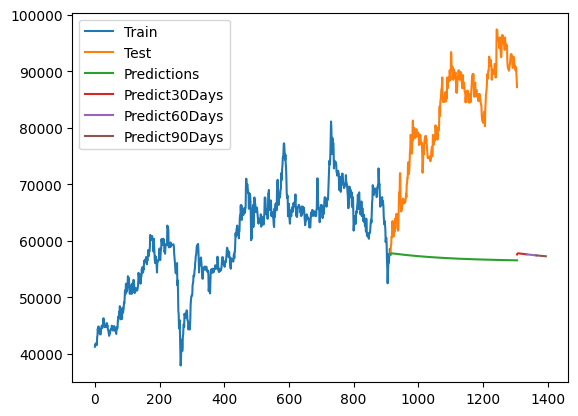

In [13]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Train', 'Test', 'Predictions','Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()

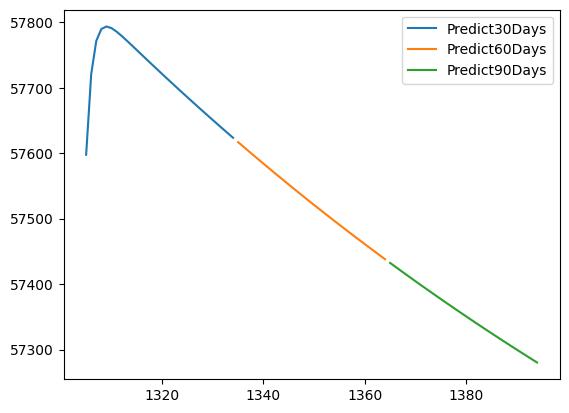

In [14]:
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()